<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_5.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(multilevel-notebook)=
# Il modello lineare gerarchico

In [79]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bambi as bmb
import xarray as xr
import pingouin as pg

In [80]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In questo capitolo, dimostriamo come eseguire una regressione lineare gerarchica bayesiana. Prenderemo in considerazione un insieme di dati in cui ci sono più soggetti, ognuno dei quali con diverse osservazioni. Confronteremo tre modelli: il modello di "complete pooling", che ignora completamente la struttura a cluster dei dati; il modello di "no pooling", che, all'estremo opposto, considera separatamente ogni gruppo di dati; e infine il modello di "partial pooling", che tiene conto delle differenze nelle pendenze e nelle intercette all'interno di ciascun cluster di dati, trattandole come variabili casuali estratte da una popolazione normale, che ha una media e una varianza comune a tutti i gruppi.

Quest'ultimo modello, il "partial pooling", riconosce la struttura gerarchica dei dati e cerca di bilanciare tra l'approccio completamente separato del "no pooling" e l'assunzione uniforme del "complete pooling". In questo modo, le stime degli effetti individuali sono influenzate sia dai dati specifici del gruppo che dalle informazioni condivise tra tutti i gruppi. La variazione tra i gruppi viene quindi considerata, ma viene anche moderata attraverso un processo noto come "shrinkage", che aiuta a evitare conclusioni eccessivamente influenzate dai dati anomali o dai gruppi di piccole dimensioni.

Nella seguente discussione, utilizzeremo il dataset `sleepstudy`, derivato dallo studio descritto in Belenky et al. (2003) e reso popolare nel pacchetto R lme4. Questo dataset contiene il tempo medio di reazione al giorno (in millisecondi) su una serie di test per il gruppo più soggetto a deprivazione del sonno in uno studio sulla privazione del sonno. I primi due giorni dello studio sono considerati come adattamento e allenamento, il terzo giorno è una base di riferimento, e la deprivazione del sonno ha inizio dopo il terzo giorno. I soggetti di questo gruppo sono stati limitati a 3 ore di sonno per notte.

## EDA

Iniziamo importando i dati e ispezionando la struttura delle osservazioni suddivise nei diversi cluster. 

In [81]:
data = bmb.load_data("sleepstudy")
data.head()

Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308

Eliminiamo le righe in cui la colonna "Days" ha valore 0 o 1 dal dataset "sleepstudy" utilizzando il seguente codice:

In [83]:
data = data[data['Days'].isin([0, 1]) == False]
data.head()

Reaction  Days  Subject
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308
5  414.6901     5      308
6  382.2038     6      308

Analizziamo il tempo di reazione medio in relazione ai giorni di deprivazione del sonno, osservando come questo varia per ciascun soggetto coinvolto nello studio.

In [84]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(16, 7.5), sharey=True, sharex=True, dpi=300, constrained_layout=True)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    # Remove axis labels for individual plots
    for ax in axes_flat:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set x-axis ticks for the last row
    for ax in axes[-1]:
        ax.xaxis.set_ticks([0, 2, 4, 6, 8])

    return axes

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_90355/2849669524.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)


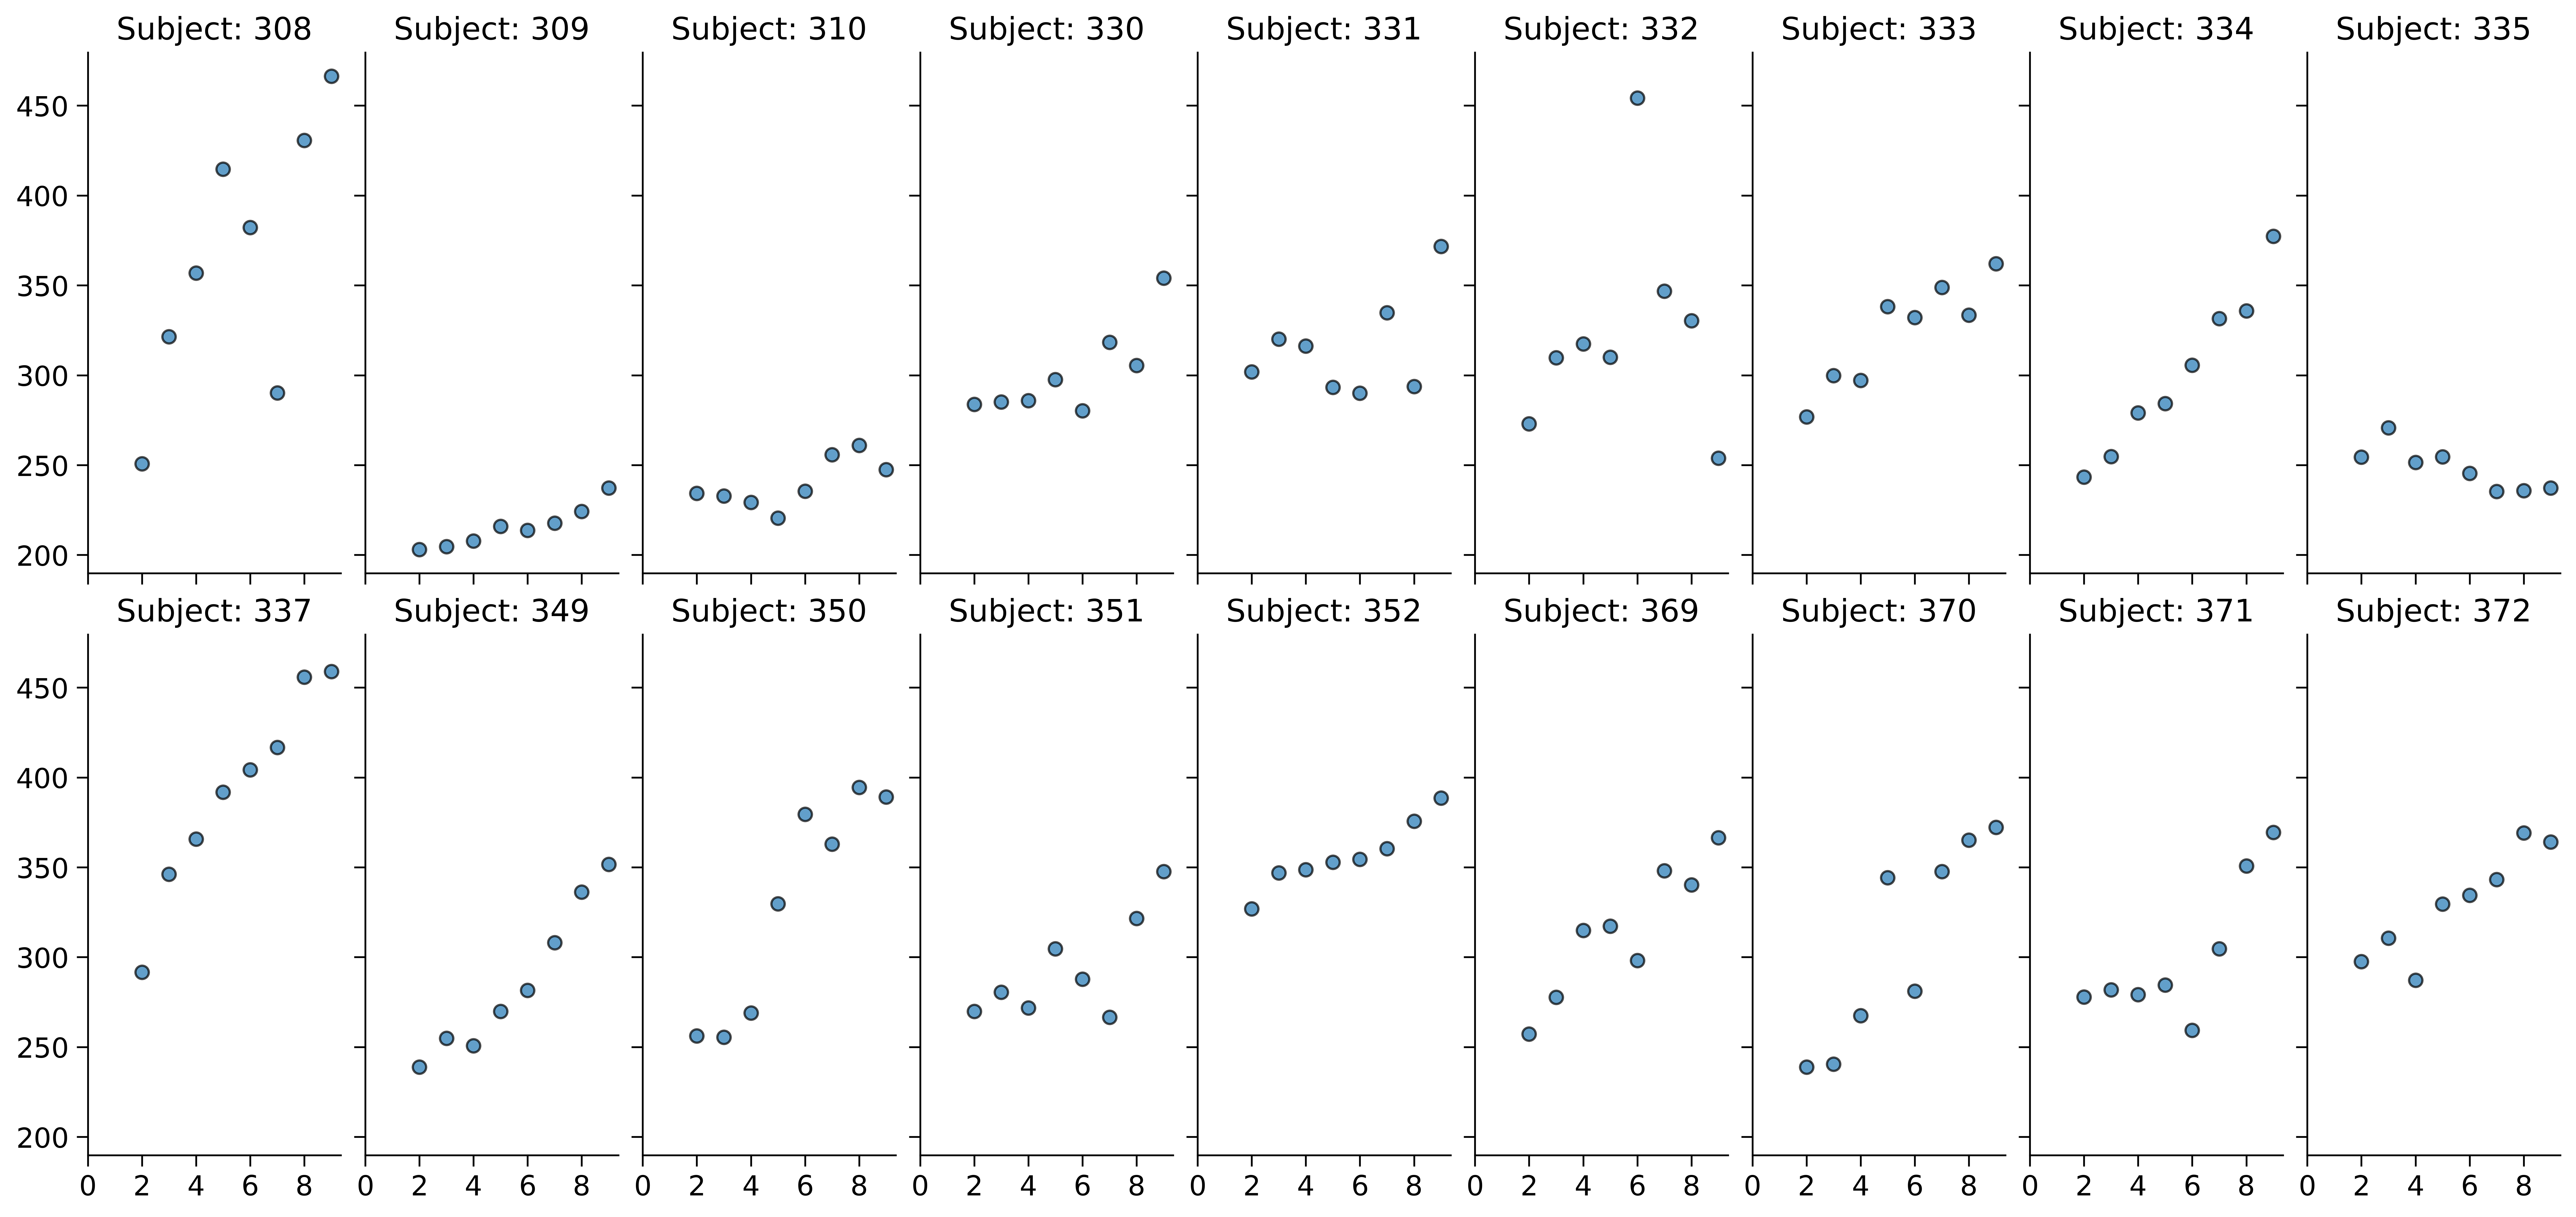

In [85]:
plot_data(data);

## Modello complete pooling

Il modello complete pooling tratta tutte le osservazioni come se fossero indipendenti, aggregandole in un unico gruppo. In questo modello, le rette di regressione lineare per tutti i soggetti hanno la stessa pendenza e la stessa intercetta. Il modello può essere descritto esplicitamente come segue:

Se disponiamo di $ m $ soggetti e ciascun soggetto $ i $ ha $ n_i $ osservazioni, il modello può essere definito da:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m, \text{ e per l'osservazione } j = 1, \ldots, n_i:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha + \beta \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2),
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione per il soggetto $ i $ al giorno $ j $.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $ i $ all'osservazione $ j $.
- $\alpha$ è l'intercetta comune a tutti i soggetti.
- $\beta$ è la pendenza comune a tutti i soggetti.
- $\epsilon_{ij}$ è il termine di errore casuale per il soggetto $ i $ all'osservazione $ j $, che si suppone sia distribuito normalmente con media 0 e varianza costante $ \sigma^2 $.

Questo modello non distingue tra i gruppi di osservazoni che appartengono a soggetti diversi e stima un'unica pendenza e un'unica intercetta dai dati di tutti i soggetti. In Bambi, questo modello può essere specificato utilizzando solo la variabile `Days` come predittore, senza includere il `Subject` come fattore.

In [93]:
model_pooling = bmb.Model("Reaction ~ 1 + Days", data)

Eseguiamo il campionamento MCMC.

In [94]:
results_pooling = model_pooling.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Intercept, Days]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [56]:
az.summary(results_pooling, kind="stats", round_to=2)

mean     sd  hdi_3%  hdi_97%
Intercept       245.21  11.39  221.40   264.63
Days             11.42   1.92    7.91    15.17
Reaction_sigma   51.19   3.05   45.67    57.23

## Modello no-pooling

Il modello no-pooling tratta ogni soggetto come indipendente e adatta una retta di regressione  separata per ciascun soggetto. Se disponiamo di $ m $ soggetti e ciascun soggetto $ i $ ha $ n_i $ osservazioni, il modello può essere definito da:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha_i + \beta_i \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2), \quad j = 1, \ldots, n_i,
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione per il soggetto $ i $ al giorno $ j $.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $ i $ all'osservazione $ j $.
- $\alpha_i$ è l'intercetta per il soggetto $ i $.
- $\beta_i$ è la pendenza per il soggetto $ i $.
- $\epsilon_{ij}$ è il termine di errore casuale per il soggetto $ i $ all'osservazione $ j $, che si suppone sia distribuito normalmente con media 0 e varianza costante $ \sigma^2 $.

Questo modello non fa alcuna ipotesi sulle relazioni tra diversi soggetti e stima la pendenza e l'intercetta di ciascun soggetto indipendentemente dagli altri soggetti. In Bambi, questo modello viene specificato con l'interazione tra `Days` e `Subject`, come descritto in seguito.

In [95]:
model_no_pooling = bmb.Model('Reaction ~ Days * C(Subject)', data=data)
results_no_pooling = model_no_pooling.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Intercept, Days, C(Subject), Days:C(Subject)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [58]:
az.summary(results_no_pooling, kind="stats", round_to=2)

mean     sd  hdi_3%  hdi_97%
Intercept             246.98  22.92  203.70   290.42
Days                   21.30   3.84   14.20    28.67
C(Subject)[309]       -55.29  32.76 -117.91     6.03
C(Subject)[310]       -29.64  32.50  -89.50    31.04
C(Subject)[330]         9.81  32.78  -53.50    70.71
C(Subject)[331]        41.54  33.75  -20.42   104.73
C(Subject)[332]        64.34  32.60   -0.04   121.29
C(Subject)[333]        16.55  33.33  -46.47    79.02
C(Subject)[334]       -44.93  32.69 -105.62    16.52
C(Subject)[335]        24.00  32.65  -35.54    88.72
C(Subject)[337]        21.00  32.73  -40.98    81.92
C(Subject)[349]       -50.52  33.36 -113.89    12.20
C(Subject)[350]       -45.41  33.14 -109.43    13.74
C(Subject)[351]         0.08  33.00  -58.95    62.11
C(Subject)[352]        69.29  33.10    7.67   131.52
C(Subject)[369]        -8.03  33.49  -71.54    53.23
C(Subject)[370]       -53.38  33.19 -116.06     7.50
C(Subject)[371]       -14.11  33.35  -77.30    47.74
C(Subject)[372]        21.81  33.27  -44.51    80.22
Days:C(Subject)[309]  -16.97   5.50  -27.55    -6.85
Days:C(Subject)[310]  -17.33   5.47  -27.16    -7.08
Days:C(Subject)[330]  -13.20   5.47  -23.07    -2.52
Days:C(Subject)[331]  -16.42   5.61  -26.65    -5.85
Days:C(Subject)[332]  -18.92   5.47  -29.57    -9.18
Days:C(Subject)[333]  -10.40   5.62  -20.44     0.78
Days:C(Subject)[334]   -3.24   5.49  -13.04     7.51
Days:C(Subject)[335]  -25.47   5.47  -35.54   -15.16
Days:C(Subject)[337]    1.16   5.54   -9.45    11.22
Days:C(Subject)[349]   -4.91   5.61  -15.38     5.71
Days:C(Subject)[350]    1.93   5.51   -8.83    11.68
Days:C(Subject)[351]  -12.80   5.49  -22.87    -2.51
Days:C(Subject)[352]  -13.95   5.52  -23.82    -3.33
Days:C(Subject)[369]   -7.49   5.66  -18.42     2.80
Days:C(Subject)[370]   -0.65   5.61  -11.03     9.58
Days:C(Subject)[371]   -8.92   5.63  -19.16     2.06
Days:C(Subject)[372]  -10.26   5.58  -20.72     0.01
Reaction_sigma         25.78   1.80   22.46    29.12

Per ricavare i coefficienti $\alpha$ delle regressioni individuali, dobbiamo sommare `Intercept` al valore del singolo soggetto. Per esempio, per il soggetto 309 abbiamo

In [59]:
246.98 + -55.29

191.69

Facciamo lo stesso per la pendenza individuale delle rette di regressione. Per il soggetto 309 otteniamo

In [60]:
21.30 + -16.97

4.330000000000002

Questi valori sono identici a quelli che si otterrebbero se adattassimo il modello di regressione separatamente per ciascun soggetto. In effetti, abbiamo fatto proprio questo, anche se utilizzando un modello unico. Per esempio, esaminiamo solo i dati del soggetto 309.

In [61]:
data_subject_309 = data[data['Subject'] == 309]
data_subject_309.shape

(8, 3)

Per questi dati, stimiamo l'intercetta e la pendenza della retta di regressione usando l'approccio frequentista mediante la funzione `linear_regression` del pacchetto `pingouin`.

In [62]:
result = pg.linear_regression(data_subject_309["Days"], data_subject_309["Reaction"])
print(result)

       names        coef        se          T          pval        r2  \
0  Intercept  191.576970  3.723259  51.454104  3.615788e-09  0.890144   
1       Days    4.357144  0.624898   6.972569  4.325982e-04  0.890144   

     adj_r2    CI[2.5%]   CI[97.5%]  
0  0.871834  182.466483  200.687457  
1  0.871834    2.828074    5.886214  


Si noti che i risultati ottenuti sono sostanzialmente gli stessi, con solo qualche minima differenza numerica. Questa discrepanza deriva dalla diversità degli approcci utilizzati: in un caso abbiamo applicato un metodo bayesiano, mentre nell'altro abbiamo adottato una tecnica di stima frequentista.

## Modello partial pooling

Il modello gerarchico, conosciuto anche come modello di "partial pooling", consente di gestire la complessità presente nei dati raggruppati o clusterizzati, come nel caso presente. La regressione lineare classica presume che ogni osservazione sia indipendente dalle altre, ma questa ipotesi viene meno quando i dati sono organizzati in gruppi. Le osservazioni all'interno dello stesso gruppo tendono ad essere più correlate tra loro rispetto a quelle in gruppi diversi. Trascurare questa struttura gerarchica potrebbe portare a stime errate e conclusioni fuorvianti.

Il modello gerarchico affronta questo problema introducendo la nozione di effetti casuali, in contrapposizione agli effetti fissi del modello classico. Gli effetti fissi rappresentano l'effetto medio di una variabile predittiva su tutti gli individui o gruppi, mentre gli effetti casuali considerano come l'effetto di una variabile possa variare da un gruppo all'altro. Mentre gli effetti fissi sono comuni a tutto il dataset, gli effetti casuali tengono conto delle differenze tra i gruppi.

Questo modello gerarchico unisce effetti fissi e casuali per fornire una rappresentazione più accurata dei dati, quando questi mostrano relazioni gerarchiche o raggruppate. Il modello gerarchico di "partial pooling" considera le somiglianze tra i soggetti stimando un'intercetta e una pendenza comuni, ma consente anche variazioni individuali attorno a questi valori medi.

Possiamo rappresentare matematicamente il modello come segue:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m, \text{ e per l'osservazione } j = 1, \ldots, n_i:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha_i + \beta_i \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2),
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione del soggetto $i$ al giorno $j$.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $i$ all'osservazione $j$.
- $\alpha_i$ è l'intercetta per il soggetto $i$, che segue la distribuzione $\alpha_i \sim \mathcal{N}(\alpha, \tau_\alpha^2)$.
- $\beta_i$ è la pendenza per il soggetto $i$, che segue la distribuzione $\beta_i \sim \mathcal{N}(\beta, \tau_\beta^2)$.
- $\epsilon_{ij}$ è l'errore casuale per il soggetto $i$ all'osservazione $j$, distribuito normalmente con media 0 e varianza costante $\sigma^2$.

I parametri $\alpha$ e $\beta$ rappresentano l'intercetta e la pendenza medie per tutti i soggetti, e le varianze $\tau_\alpha^2$ e $\tau_\beta^2$ quantificano le differenze tra gli individui.

In questo modo, il modello gerarchico riesce a rappresentare sia le informazioni comuni a tutti i soggetti, sia le differenze individuali, considerando sia gli effetti fissi che quelli casuali. Può quindi offrire una visione più completa e realistica dei dati, tenendo conto della loro struttura gerarchica. In Bambi, questo modello può essere specificato utilizzando la variabile `Days` come predittore e includendo `Subject` come effetto casuale.

In [66]:
model_partial_pooling = bmb.Model(
    "Reaction ~ 1 + Days + (Days | Subject)", data, categorical="Subject"
)

Eseguiamo il campionamento.

In [96]:
results_partial_pooling = model_partial_pooling.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Esaminiamo i risultati.

In [68]:
az.summary(results_partial_pooling, kind="stats", round_to=2)

mean     sd  hdi_3%  hdi_97%
Intercept           245.25   9.59  227.24   263.72
Days                 11.33   1.91    7.86    15.09
Reaction_sigma       26.00   1.83   22.50    29.25
1|Subject_sigma      31.61   8.80   16.30    47.99
Days|Subject_sigma    6.93   1.65    4.23    10.16
1|Subject[308]       10.01  18.97  -23.96    47.18
1|Subject[309]      -43.14  20.03  -79.97    -6.03
1|Subject[310]      -25.41  19.49  -61.43    11.26
1|Subject[330]        4.94  18.03  -27.66    39.43
1|Subject[331]       22.44  18.90  -14.24    57.05
1|Subject[332]       34.82  19.44    0.13    73.58
1|Subject[333]       11.05  18.60  -24.98    44.56
1|Subject[334]      -22.63  19.30  -60.36    12.23
1|Subject[335]        1.94  19.06  -35.31    37.84
1|Subject[337]       26.37  19.61  -10.11    62.68
1|Subject[349]      -27.84  18.97  -62.79     8.07
1|Subject[350]      -17.03  19.37  -51.46    21.34
1|Subject[351]       -1.40  18.35  -35.37    35.18
1|Subject[352]       43.67  20.74    4.38    81.22
1|Subject[369]       -1.30  18.18  -34.95    33.80
1|Subject[370]      -25.26  18.91  -62.57     7.99
1|Subject[371]       -7.16  18.40  -43.26    25.51
1|Subject[372]       15.22  18.89  -19.74    50.63
Days|Subject[308]     8.28   3.46    1.63    14.64
Days|Subject[309]    -8.14   3.54  -14.86    -1.60
Days|Subject[310]    -7.26   3.48  -13.47    -0.41
Days|Subject[330]    -2.07   3.27   -8.16     4.09
Days|Subject[331]    -3.07   3.39   -9.48     3.13
Days|Subject[332]    -3.88   3.43  -10.31     2.47
Days|Subject[333]     0.63   3.29   -5.73     6.47
Days|Subject[334]     3.36   3.48   -3.00    10.01
Days|Subject[335]   -11.18   3.47  -17.59    -4.78
Days|Subject[337]    10.00   3.50    3.54    16.64
Days|Subject[349]     1.71   3.38   -4.57     8.10
Days|Subject[350]     7.42   3.49    0.61    13.86
Days|Subject[351]    -2.15   3.30   -8.62     3.74
Days|Subject[352]     0.24   3.51   -6.35     6.64
Days|Subject[369]     1.64   3.29   -4.12     8.19
Days|Subject[370]     4.93   3.42   -1.23    11.80
Days|Subject[371]     0.24   3.31   -6.03     6.42
Days|Subject[372]     0.94   3.30   -5.09     7.47

Consideriamo il soggetto 309. Per questo soggetto l'intercetta è

In [69]:
245.25 + -43.14

202.11

e la pendenza della retta di regressione è

In [70]:
11.33 + -8.14

3.1899999999999995

Si noti che questi valori sono diversi da quelli ottenuti con la procedura di no-pooling. Entrambi i modelli di no pooling e il modello gerarchico di partial pooling riconoscono che ci possono essere differenze tra i diversi gruppi (o soggetti) nel dataset, ma gestiscono queste differenze in modi diversi.

Nel modello di no pooling, ogni gruppo viene trattato in modo completamente indipendente dagli altri. Ogni intercetta e pendenza viene stimata separatamente per ogni gruppo, senza fare riferimento agli altri gruppi. In altre parole, si adatta una regressione lineare separata per ciascun gruppo. Ciò significa che se si hanno molti gruppi, ci saranno molti parametri da stimare.

Questo approccio può catturare le differenze tra i gruppi molto accuratamente se ci sono molte osservazioni in ogni gruppo, ma può essere problematico se ci sono poche osservazioni per gruppo. Inoltre, non sfrutta le informazioni comuni tra i gruppi e può portare a stime molto variabili.

Il modello gerarchico di partial pooling, invece, riconosce che anche se ci sono differenze tra i gruppi, questi potrebbero condividere alcune caratteristiche comuni. Invece di stimare le intercette e pendenze completamente separatamente per ogni gruppo, stima una media comune e una varianza comune per l'intercetta e la pendenza, e poi permette a ciascun gruppo di variare attorno a questi valori comuni.

Questo porta al concetto di "shrinkage". Le stime delle intercette e pendenze per ciascun gruppo tendono a essere "retratte" o "compresso" verso i valori medi. Se un gruppo ha poche osservazioni, la sua stima sarà più fortemente influenzata dalla media comune. Se ha molte osservazioni, la sua stima sarà meno influenzata dalla media comune. In questo modo, il modello riesce a bilanciare tra catturare le differenze tra i gruppi e sfruttare le informazioni comuni.

In sintesi, la differenza principale tra il modello di no pooling e il modello gerarchico di partial pooling sta nel modo in cui gestiscono le intercette e pendenze individuali:

- Il modello di no pooling tratta ogni gruppo separatamente, stimando le intercette e pendenze individuali senza considerare gli altri gruppi.
- Il modello gerarchico di partial pooling stima le intercette e pendenze comuni e permette a ciascun gruppo di variare attorno a questi valori comuni, utilizzando il concetto di shrinkage.

Il modello di no pooling può essere più adatto se i gruppi sono veramente indipendenti e molto diversi tra loro, mentre il modello gerarchico può essere più efficace quando ci sono somiglianze tra i gruppi che possono essere sfruttate per ottenere stime più precise e robuste.

### Modello gerarchico e la distribuzione dei coefficienti

Più speficicatamente, nel modello gerarchico di partial pooling, gli effetti casuali (come le intercette e le pendenze per ogni gruppo o soggetto) sono considerati come realizzazioni di variabili casuali. Questa è una differenza fondamentale rispetto al modello di no pooling, dove ogni coefficiente è trattato come un parametro fisso.

Nel modello gerarchico, si suppone che gli effetti casuali seguano una distribuzione normale. Questo significa che ogni coefficiente individuale (ad esempio, l'intercetta per un particolare soggetto) è considerato come un campione estratto da una popolazione normale. La popolazione ha una media e una varianza che sono comuni a tutti i gruppi, e queste vengono stimate dai dati.

Ad esempio, le intercette individuali $\alpha_i$ possono essere modellate come:

$$
\alpha_i \sim \mathcal{N}(\alpha, \tau_\alpha^2),
$$

dove $\alpha$ è l'intercetta media per tutti i soggetti e $\tau_\alpha^2$ è la varianza delle intercette tra i soggetti. Analogamente, le pendenze individuali $\beta_i$ possono essere modellate come:

$$
\beta_i \sim \mathcal{N}(\beta, \tau_\beta^2),
$$

dove $\beta$ è la pendenza media e $\tau_\beta^2$ è la varianza delle pendenze.

### Implicazioni

Questa struttura ha diverse implicazioni importanti:

1. **Shrinkage:** Come discusso in precedenza, le stime dei coefficienti individuali tendono a essere "retratte" verso i valori medi. Questo aiuta a stabilizzare le stime, specialmente quando ci sono poche osservazioni per gruppo.

2. **Scambio di Informazioni tra i Gruppi:** Poiché i coefficienti individuali sono considerati come estratti dalla stessa distribuzione, ciò permette uno scambio di informazioni tra i gruppi. Se un gruppo ha molte osservazioni, può aiutare a informare le stime per un gruppo con poche osservazioni.

3. **Interpretazione Ierarchica:** Il modello riconosce una struttura gerarchica nei dati, con osservazioni raggruppate all'interno di gruppi, e gruppi che condividono caratteristiche comuni. Questa struttura può riflettere una realtà sottostante nella quale gli individui o i gruppi non sono completamente indipendenti l'uno dall'altro.

In conclusione, il modello gerarchico di partial pooling offre un quadro flessibile e potente per analizzare dati raggruppati o clusterizzati, riconoscendo sia le somiglianze che le differenze tra i gruppi e utilizzando una struttura probabilistica per modellare le relazioni tra di loro.

## Interpretazione

Iniziamo considerando le stime a posteriori degli effetti fissi.

In [76]:
az.summary(results_partial_pooling, var_names=["Intercept", "Days"], kind="stats", round_to=2)

mean    sd  hdi_3%  hdi_97%
Intercept  245.25  9.59  227.24   263.72
Days        11.33  1.91    7.86    15.09

In media, il tempo di reazione medio delle persone all'inizio dello studio è compreso tra 227 e 264 millisecondi. Con ogni giorno aggiuntivo di privazione del sonno, i tempi di reazione medi aumentano, in media, tra 7.9 e 15.1 millisecondi.

L'interpretazione degli effetti fissi è semplice. Ma quest'analisi sarebbe incompleta e fuorviante se non valutiamo i termini specifici per i singoli soggetti che abbiamo aggiunto al modello. Questi termini ci dicono quanto i soggetti differiscono l'uno dall'altro in termini di tempo di reazione iniziale e dell'associazione tra giorni di privazione del sonno e tempi di reazione.

Di seguito, utilizziamo ArviZ per ottenere un traceplot delle intercetti specifiche per i soggetti `1|Subject` e delle pendenze `Days|Subject`. Questo traceplot contiene due colonne. A sinistra, abbiamo le distribuzioni posteriori e a destra abbiamo i trace-plots. L'aspetto casuale stazionario, o l'apparenza di rumore bianco, ci dice che il campionatore ha raggiunto la convergenza e le catene sono ben mescolate.

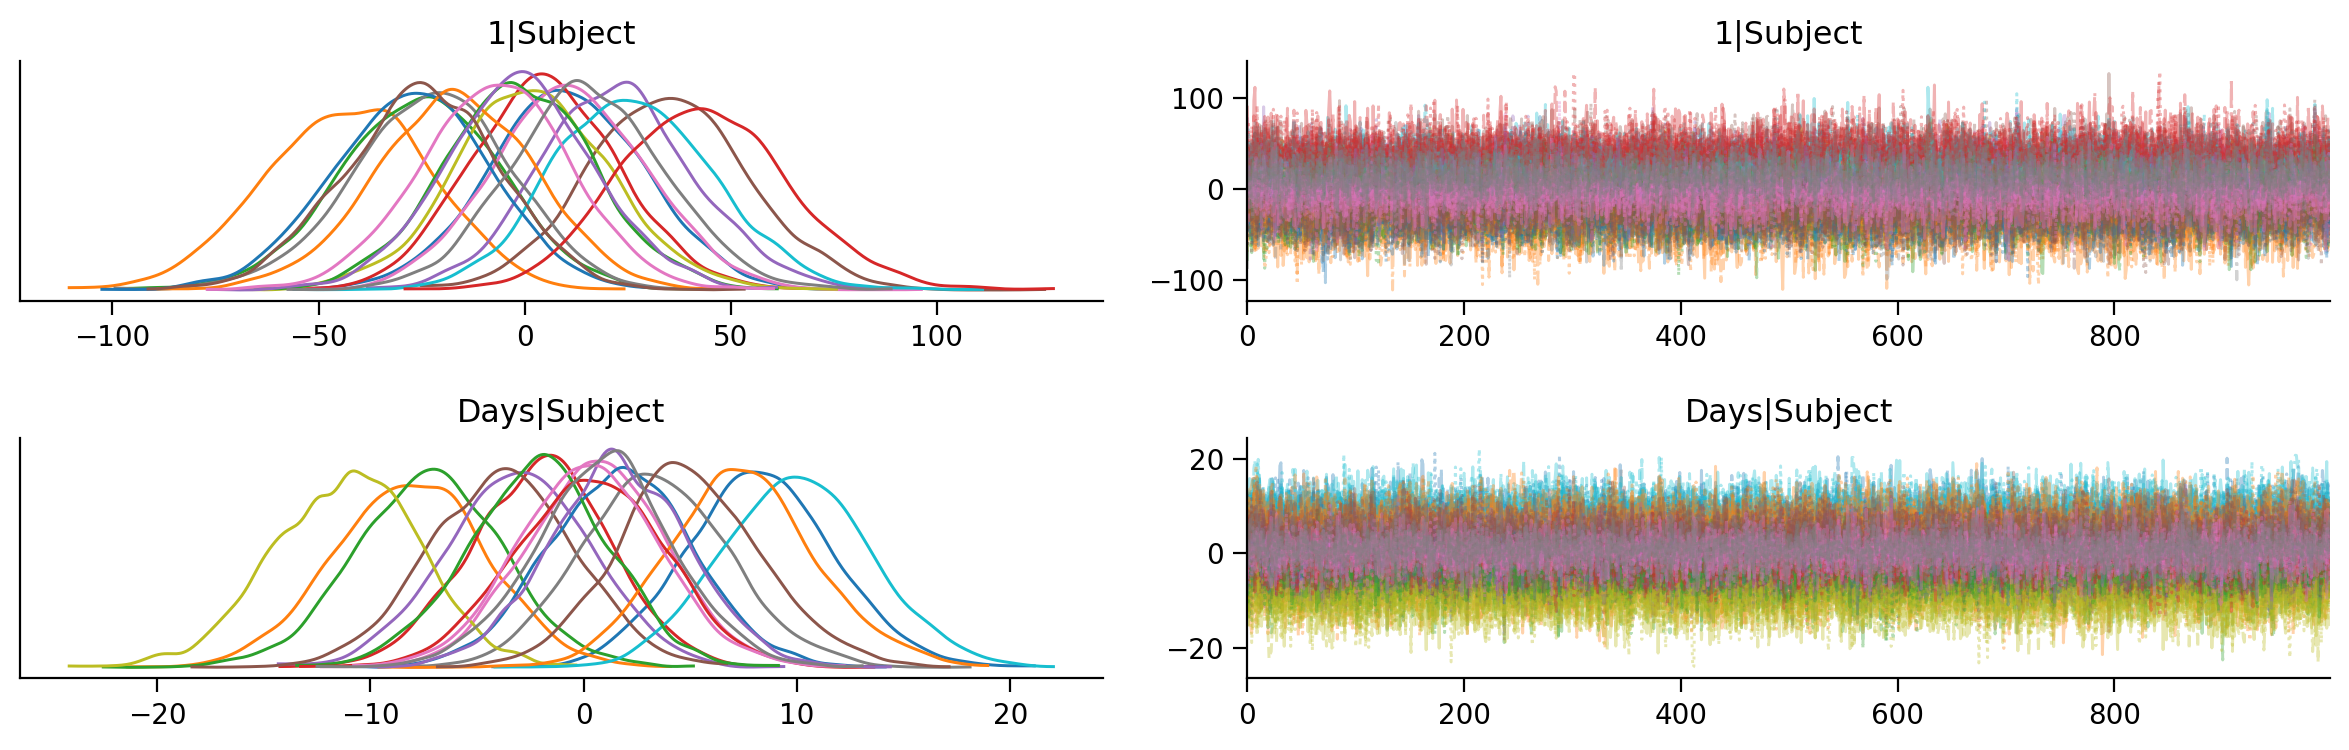

In [74]:
az.plot_trace(results_partial_pooling, combined=True, var_names=["1|Subject", "Days|Subject"]);

Dall'ampiezza delle distribuzioni a posteriori delle intercette per i singoli soggetti possiamo vedere che il tempo di reazione medio iniziale per un determinato soggetto può differire notevolmente dalla media generale che abbiamo visto nella tabella precedente. C'è anche una grande differenza nelle pendenze. Alcuni soggetti vedono aumentare rapidamente i loro tempi di reazione quando vengono deprivati del sonno, mentre altri hanno una tolleranza migliore e peggiorano più lentamente. 

Una rappresentazione grafica della stima a posteriore dei parametri e dei dati si ottiene con `az.plot_forest()`.

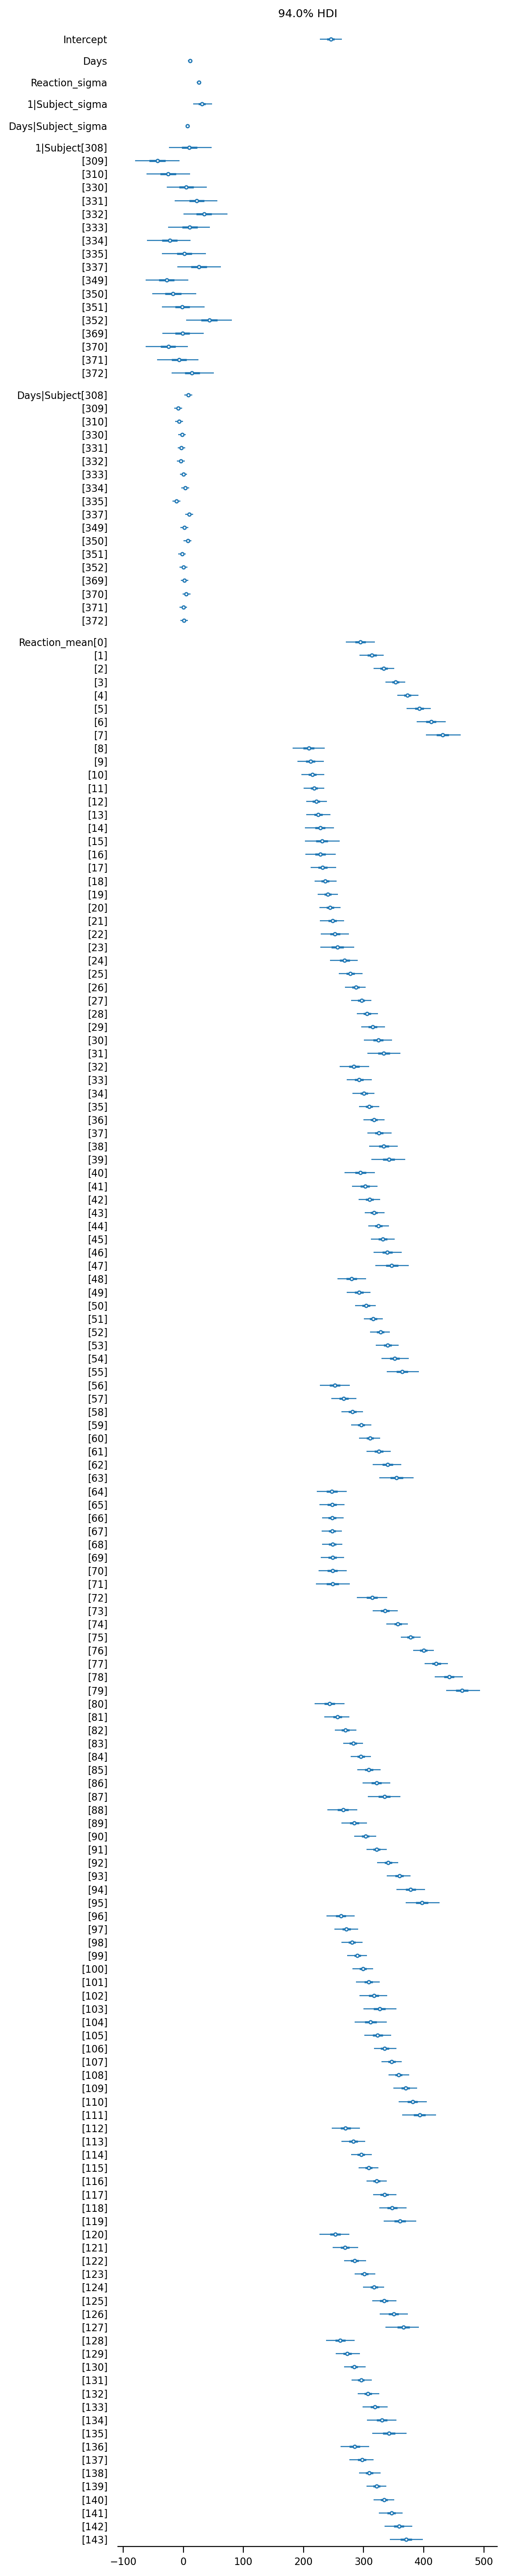

In [91]:
az.plot_forest(data=results_partial_pooling, r_hat=False, combined=True, textsize=8);

In sintesi, il modello gerarchico cattura il comportamento che abbiamo visto nella fase di esplorazione dei dati. Le persone differiscono sia nei tempi di reazione iniziali che nel modo in cui questi tempi di reazione sono influenzati dai giorni di deprivazione del sonno. Possiamo dunque giungere alle seguenti conclusioni:

- Il tempo di reazione medio delle persone aumenta quando sono deprivate del sonno.
- I soggetti hanno tempi di reazione diversi all'inizio dello studio.
- Alcuni soggetti sono più colpiti dalla privazione del sonno rispetto ad altri.
  
Ma c'è un'altra domanda a cui non abbiamo ancora risposto: I tempi di reazione iniziali sono associati a quanto la deprivazione del sonno influisce sull'evoluzione dei tempi di reazione? 

Creiamo un diagramma a dispersione per visualizzare le stime a posteriori congiunte delle intercette e delle pendenze specifiche per i soggetti. Questo grafico usa colori diversi per i soggetti. Se guardiamo il quadro generale, cioè trascurando i ragruppamenti dei dati in base ai soggetti, possiamo concludere che non c'è associazione tra l'intercetta e la pendenza. In altre parole, avere tempi di reazione iniziali più bassi o più alti non dice nulla su quanto la deprivazione del sonno influisca sul tempo di reazione medio di un determinato soggetto.

D'altra parte, se guardiamo la distribuzione a posteriori congiunta per un determinato individuo, possiamo vedere una correlazione negativa tra l'intercetta e la pendenza. Questo indica che, condizionalmente a un determinato soggetto, le stime a posteriori dell'intercetta e della pendenza non sono indipendenti. 

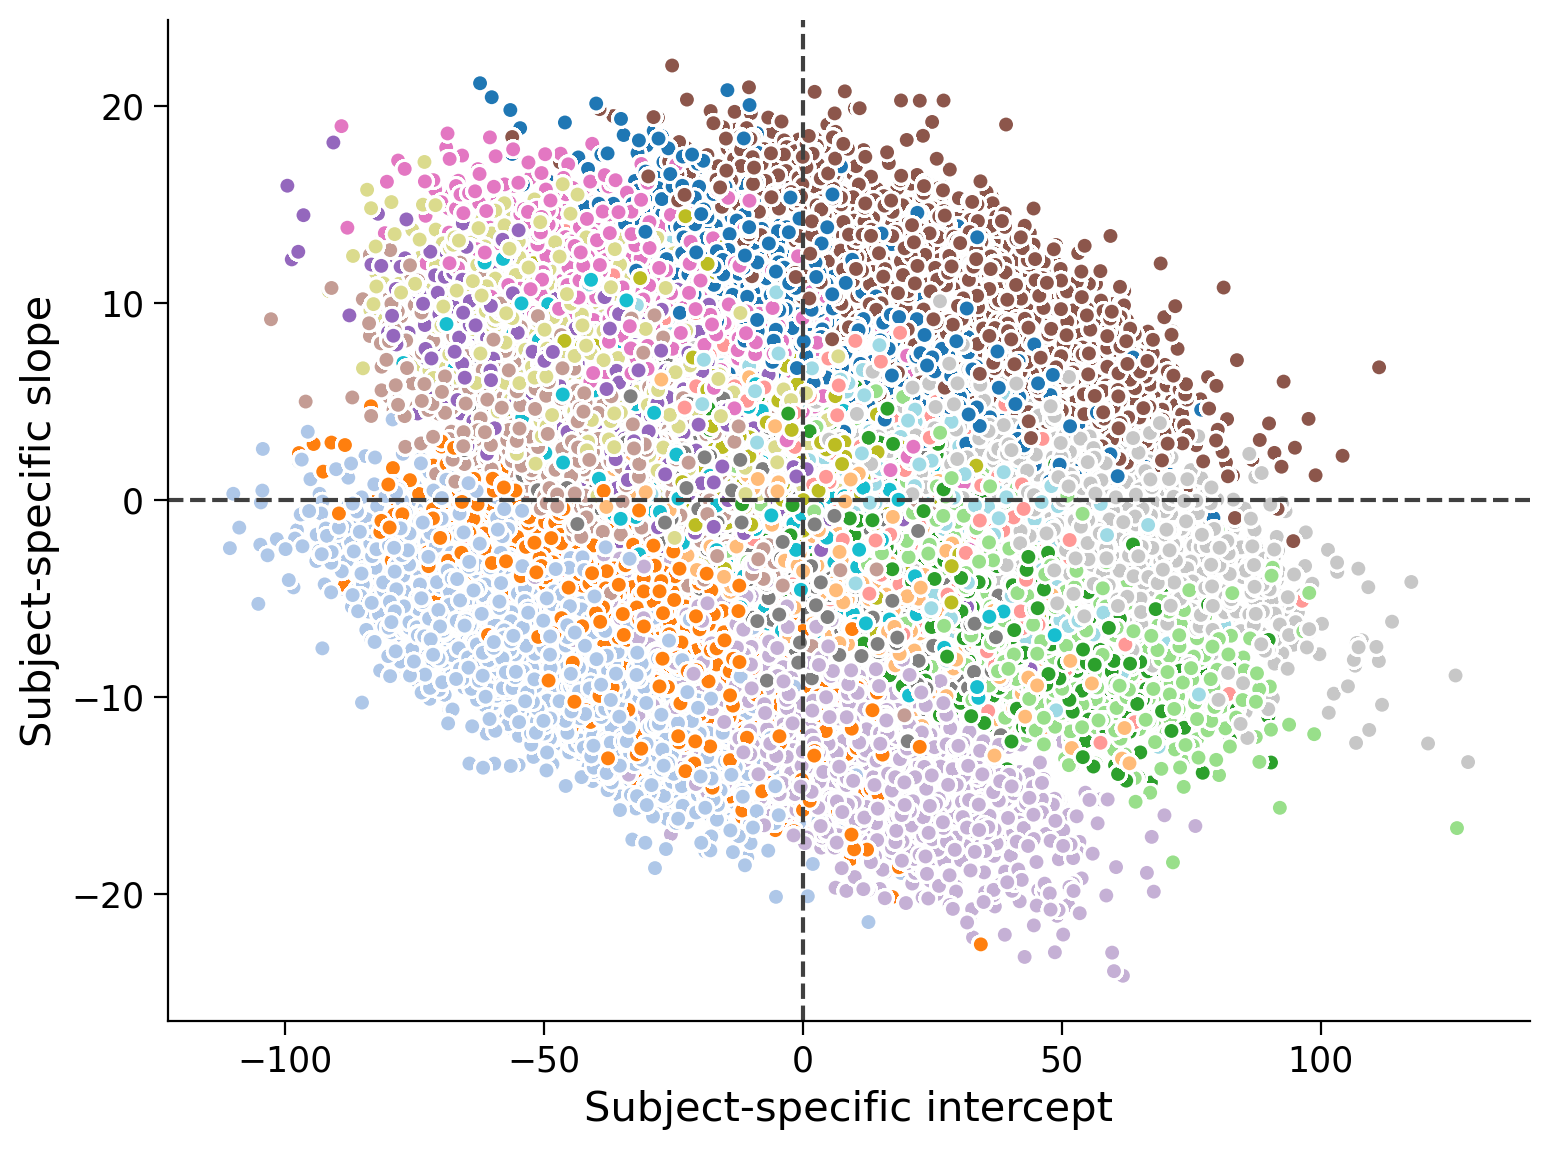

In [77]:
#  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(results_partial_pooling, num_samples=500)

_, ax = plt.subplots()

results_partial_pooling.posterior.plot.scatter(
    x="1|Subject", y="Days|Subject",
    hue="Subject__factor_dim",
    add_colorbar=False,
    add_legend=False,
    cmap="tab20",
    edgecolors=None,
)

ax.axhline(c="0.25", ls="--")
ax.axvline(c="0.25", ls="--")
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope");

## Confronto dei modelli

Un aspetto finale e cruciale del nostro studio riguarda il confronto tra i diversi modelli che abbiamo esaminato. La nostra intenzione è determinare quale modello fornisce una rappresentazione migliore dei dati, trovando un equilibrio appropriato tra l'accuratezza del modello e la sua complessità, cioè la parsimonia.

Per raggiungere questo scopo, faremo uso della metrica ELPD (Expected Log Predictive Density), che abbiamo introdotto in precedenza. ELPD ci consente di valutare un modello in termini di adattamento ai dati, considerando sia l'accuratezza delle previsioni che la complessità del modello.

### Utilizzo di `az.compare()` 

In Python, possiamo sfruttare la funzione `az.compare()` per confrontare direttamente modelli bayesiani. Questa funzione accetta un dizionario contenente gli oggetti `InferenceData`, risultanti dalla funzione `Model.fit()`, e restituisce un dataframe. I modelli vengono ordinati dal migliore al peggiore in base ai criteri selezionati, e di default, ArviZ usa il criterio di convalida incrociata "leave one out" (LOO).

#### Convalida Incrociata "Leave One Out" (LOO)

LOO è una tecnica di convalida che addestra il modello su tutti i dati disponibili tranne uno, utilizzando il singolo punto escluso come dati di test. Questo processo viene ripetuto per ogni punto dati nel set, e la media delle misure di errore fornisce una stima accurata dell'errore di generalizzazione del modello. Anche se computazionalmente impegnativa, LOO fornisce una valutazione affidabile delle prestazioni del modello. In ArviZ, la funzione `loo` implementa questo metodo seguendo un approccio bayesiano.

#### Widely Applicable Information Criterion (WAIC)

Oltre a LOO, possiamo anche utilizzare il criterio WAIC (Widely Applicable Information Criterion). Il WAIC è uno strumento per la selezione del modello che mira a trovare il modello ottimale in un insieme di candidati, equilibrando l'adattamento ai dati e la complessità del modello, evitando così il sovradattamento. WAIC è particolarmente utile nel contesto bayesiano, poiché tiene conto dell'incertezza associata ai parametri del modello.

Sia LOO che WAIC possono essere visti come stime empiriche dell'ELPD, fornendo un quadro comprensivo delle prestazioni dei modelli.

### Conclusione

Utilizzando la funzione `az.compare()`, siamo in grado di effettuare una comparazione rapida ed efficace tra i diversi modelli, valutandoli secondo i criteri LOO e WAIC. Nel nostro caso specifico, il modello di "partial pooling" emerge come il migliore, presentando il valore ELPD stimato più alto. Questo risultato conferma la validità del modello nel rappresentare la struttura dei dati, tenendo conto delle differenze individuali all'interno dei cluster, e fornendo una stima coerente e informativa dell'effetto della deprivazione del sonno sul tempo di reazione.

In [97]:
models_dict = {
    "pooling": results_pooling,
    "no_pooling": results_no_pooling,
    "partial_pooling": results_partial_pooling
}
df_compare = az.compare(models_dict)
df_compare

/Users/corrado/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/corrado/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff    weight         se  \
partial_pooling     0 -691.966114  30.502086    0.00000  0.899915  21.350760   
no_pooling          1 -694.918224  36.470411    2.95211  0.050246  21.758607   
pooling             2 -772.135354   3.001084   80.16924  0.049839   9.020316   

                      dse  warning scale  
partial_pooling   0.00000     True   log  
no_pooling        3.52458     True   log  
pooling          19.96751    False   log

È importante sottolineare che, per ottenere una stima dell'ELPD (Expected Log Predictive Density), è necessario includere l'opzione `idata_kwargs={"log_likelihood": True}` all'interno della funzione responsabile dell'esecuzione del campionamento MCMC.

La figura che segue illustra visivamente le informazioni rilevanti per il confronto tra i diversi modelli. In grigio è indicata l'incertezza nella stima della differenza tra i valori ELPD dei diversi modelli.

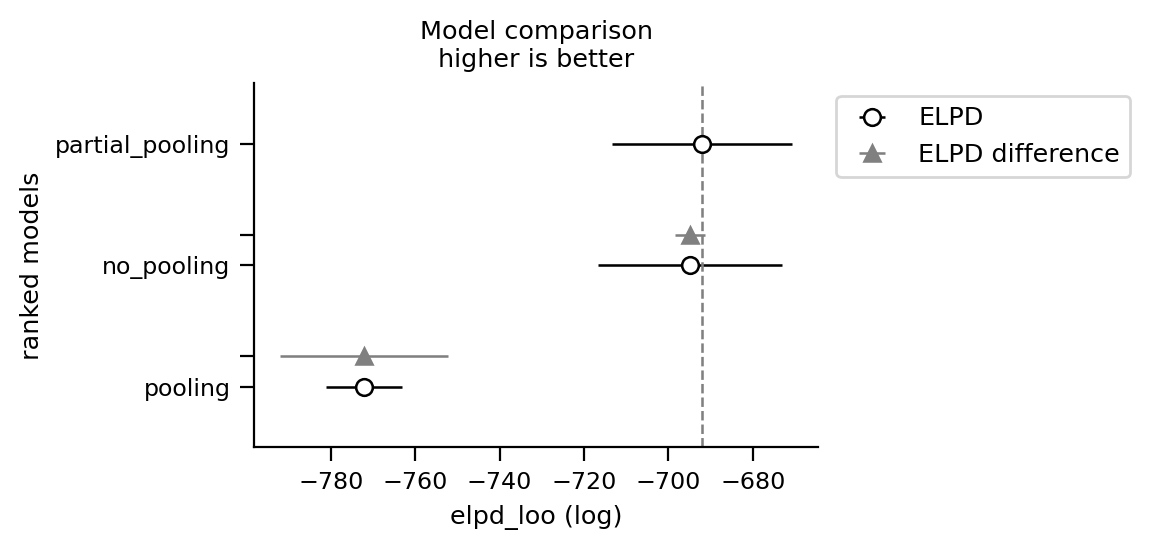

In [98]:
az.plot_compare(df_compare, insample_dev=False);

Il confronto tra i modelli guida il processo di selezione. In particolare, la comparazione tra il modello di partial-pooling e il modello completo di pooling è resa chiara dall'`elpd_diff` di 80.17 e dal suo errore standard di 19.97. Questi valori indicano inequivocabilmente che il modello di partial-pooling è superiore.

La situazione diventa più sfumata quando confrontiamo il modello di partial-pooling con il modello di no-pooling. In questo caso, le stime dell'ELPD mostrano una grande sovrapposizione, suggerendo che non c'è una differenza netta tra i due modelli in termini di adattamento ai dati.

Tuttavia, nonostante la vicinanza dei valori di ELPD, il modello di partial-pooling è da preferire. La ragione risiede nelle sue proprietà: esso fornisce stime più robuste e conservative delle differenze individuali. A differenza del modello di no-pooling, che può essere troppo sensibile alle variazioni all'interno dei cluster, il modello di partial-pooling incorpora un equilibrio tra la condivisione delle informazioni all'interno del gruppo e il riconoscimento delle differenze tra i gruppi. Questo lo rende più resistente alle fluttuazioni nei dati e offre una rappresentazione più affidabile delle relazioni sottostanti, rendendolo la scelta preferibile in questo contesto.

## Watermark

In [49]:
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Aug 17 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

arviz     : 0.16.1
matplotlib: 3.7.1
bambi     : 0.12.0
numpy     : 1.25.2
pandas    : 2.0.3
xarray    : 2023.7.0
pymc      : 5.7.2

Watermark: 2.4.3

